In [30]:
# Python code to merge two images side-by-side, resizing the left image (im1)
# so its height matches the right image (im2). Saves the merged image to /mnt/data/merged.png by default.
# The function accepts file paths or PIL.Image objects.
#
# Example usage at the end creates two demo images and merges them.

from PIL import Image, ImageDraw, ImageFont
import os

def _open_image(img):
    """Return a PIL.Image object. `img` can be a path or an Image already."""
    if isinstance(img, Image.Image):
        return img
    return Image.open(img)

def merge_side_by_side(im1, im2, out_path, match_to="right",
                       padding=0, bgcolor=(255,255,255), resample=Image.LANCZOS,
                       keep_alpha=False):
    """
    Merge im1 (left) and im2 (right) horizontally. The height of im1 is resized to match im2.
    
    Parameters
    - im1, im2: file paths or PIL.Image objects
    - out_path: where to save the merged image (default: /mnt/data/merged.png)
    - match_to: which image's height to match ('right' matches im2, 'left' matches im1,
                'max' uses the larger height, 'min' uses the smaller height)
    - padding: pixels of horizontal space between images
    - bgcolor: background color tuple (R,G,B) used when flattening alpha (default white)
    - resample: resampling filter for resizing (default LANCZOS)
    - keep_alpha: if True, save merged image with alpha channel (PNG RGBA). Otherwise saved as RGB.
    
    Returns path to saved file.
    """
    im1 = _open_image(im1).convert("RGBA")
    im2 = _open_image(im2).convert("RGBA")
    
    if match_to == "right":
        target_h = im2.height
    elif match_to == "left":
        target_h = im1.height
    elif match_to == "max":
        target_h = max(im1.height, im2.height)
    elif match_to == "min":
        target_h = min(im1.height, im2.height)
    else:
        raise ValueError("match_to must be 'right', 'left', 'max' or 'min'")
    
    def resize_to_height(img, h):
        if img.height == h:
            return img
        new_w = max(1, int(img.width * (h / img.height)))
        return img.resize((new_w, h), resample=resample)
    
    im1_r = resize_to_height(im1, target_h)
    im2_r = resize_to_height(im2, target_h)
    
    total_w = im1_r.width + im2_r.width + padding
    canvas = Image.new("RGBA", (total_w, target_h), (0,0,0,0))
    
    canvas.paste(im1_r, (0, 0), im1_r)
    canvas.paste(im2_r, (im1_r.width + padding, 0), im2_r)
    
    # If user doesn't want alpha, flatten on bgcolor
    if keep_alpha:
        save_img = canvas
        out_ext = os.path.splitext(out_path)[1].lower() or ".png"
        if out_ext not in [".png", ".webp"]:
            # convert to png if user requested alpha but extension isn't suitable
            out_path = os.path.splitext(out_path)[0] + ".png"
    else:
        background = Image.new("RGB", canvas.size, bgcolor)
        background.paste(canvas, mask=canvas.split()[3])  # paste using alpha as mask
        save_img = background
    
    save_img.save(out_path)
    return out_path


def image_merge(original_image_path, output_image_path, caption_text,caption_font_size,caption_height):
    from PIL import Image, ImageDraw, ImageFont
    caption_text_color = "black"
    caption_background_color = "white"

    img_original = Image.open(original_image_path).convert("RGBA")

    original_width, original_height = img_original.size

    caption_width = original_width
    
    caption_image = Image.new("RGBA", (caption_width, caption_height), caption_background_color)
    draw = ImageDraw.Draw(caption_image)
    font = ImageFont.truetype("DejaVuSans-Bold.ttf", caption_font_size)


    # Get text bounding box to calculate perfect center
    bbox = draw.textbbox((0, 0), caption_text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]

    # Calculate position to center the text
    text_x = (caption_width - text_width) / 2
    text_y = (caption_height - text_height) / 2 - 5 # A small adjustment might be needed due to baseline differences

    # Draw the text on the caption image
    draw.text(
        (text_x, text_y),
        caption_text,
        font=font,
        fill=caption_text_color
    )

    # --- 3. Merge the new image on top of img.png ---

    # Create a new blank image large enough to hold both
    # The new total height will be original_height + caption_height
    merged_height = original_height + caption_height
    merged_image = Image.new("RGBA", (original_width, merged_height), (0, 0, 0, 0)) # Fully transparent background

    # Paste the caption image at the top (0,0)
    merged_image.paste(caption_image, (0, 0))

    # Paste the original image directly below the caption image (at y = caption_height)
    merged_image.paste(img_original, (0, caption_height), img_original) # Use img_original as mask for transparency

    # --- 4. Save the final merged image ---
    merged_image.save(output_image_path)

    print(f"Successfully created '{output_image_path}' with the caption.")




Merged image saved to: SPECTRA_CC_runtime_merged.png
Successfully created 'SPECTRA_CC_runtime_merged.png' with the caption.


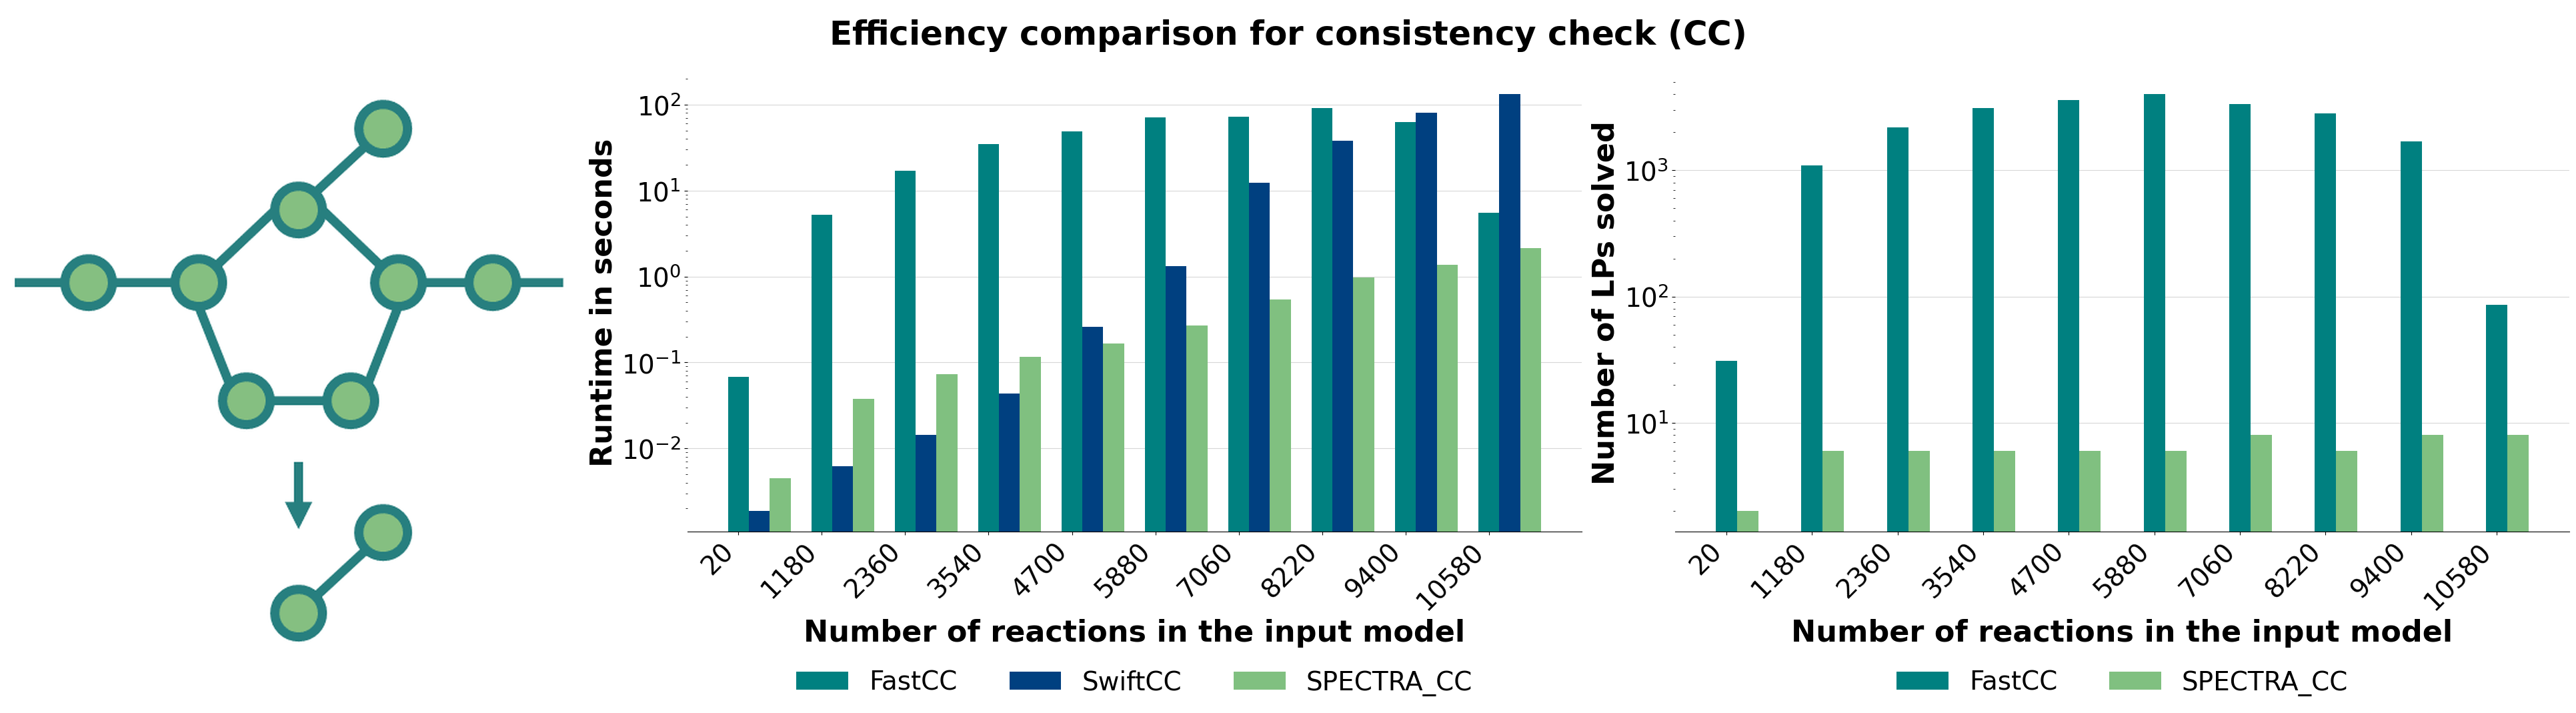

In [31]:
# merging for cc images
im1_path = os.path.join("consistency_bg","Slide2.PNG")
im2_path = os.path.join("SPECTRA_CC_runtime.png")
out_path = os.path.join("SPECTRA_CC_runtime_merged.png")


# Merge: im1 left, im2 right; resize im1's height to match im2's height
merged_path = merge_side_by_side(im1_path, im2_path, out_path=out_path, match_to="right", padding=10)
print("Merged image saved to:", merged_path)

# Display info about images
from IPython.display import display
original_image_path = out_path
output_image_path = out_path
caption_text = "Efficiency comparison for consistency check (CC)"
caption_font_size = 50
caption_height = 100

image_merge(original_image_path, output_image_path, caption_text, caption_font_size, caption_height)
display(Image.open(output_image_path))


Merged image saved to: SPECTRA_ME_runtime_merged.png
Successfully created 'SPECTRA_ME_runtime_merged.png' with the caption.


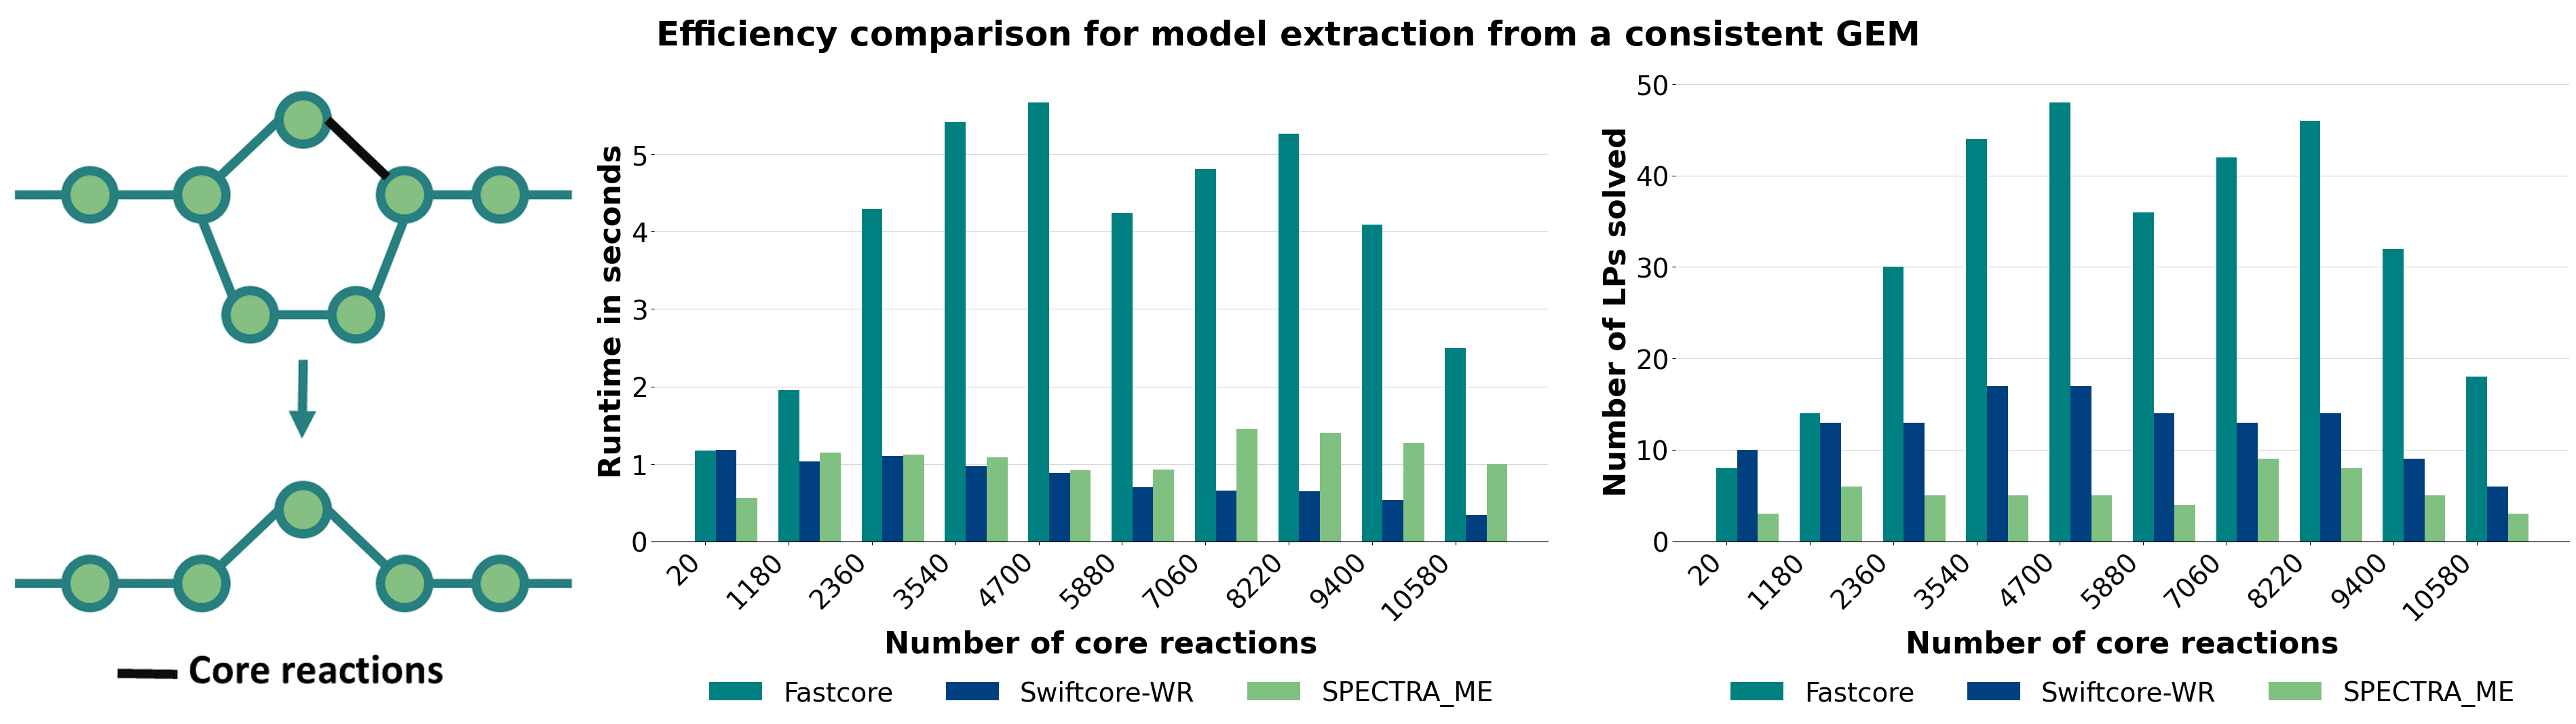

In [32]:
# merging for me images
im1_path = os.path.join("consistency_bg","Slide1.PNG")
im2_path = os.path.join("SPECTRA_ME_runtime.png")
out_path = os.path.join("SPECTRA_ME_runtime_merged.png")


# Merge: im1 left, im2 right; resize im1's height to match im2's height
merged_path = merge_side_by_side(im1_path, im2_path, out_path=out_path, match_to="right", padding=10)
print("Merged image saved to:", merged_path)

# Display info about images
from IPython.display import display
original_image_path = out_path
output_image_path = out_path
caption_text = "Efficiency comparison for model extraction from a consistent GEM"
caption_font_size = 50
caption_height = 100

image_merge(original_image_path, output_image_path, caption_text, caption_font_size, caption_height)
display(Image.open(output_image_path))

Merged image saved to: SPECTRA_CC_ME_runtime_merged.png
Successfully created 'SPECTRA_CC_ME_runtime_merged.png' with the caption.


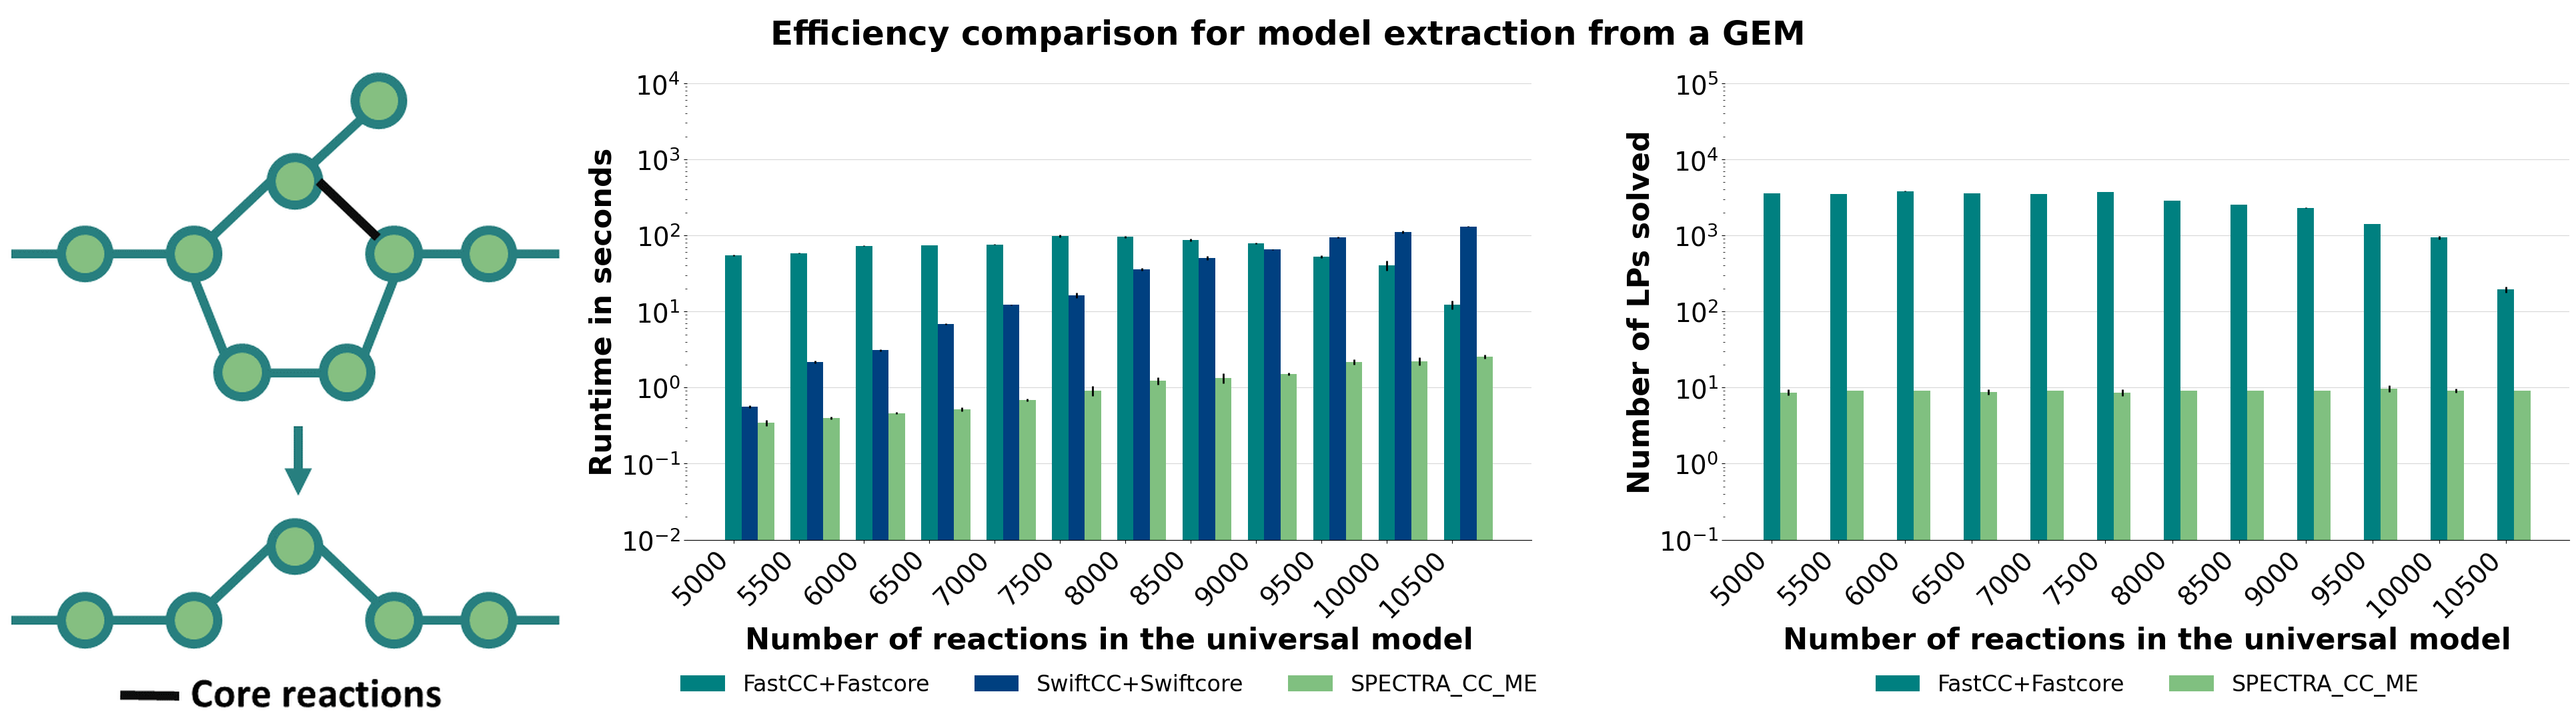

In [33]:
# merging for cc_me images
im1_path = os.path.join("consistency_bg","Slide3.PNG")
im2_path = os.path.join("SPECTRA_CC_ME_runtime.png")
out_path = os.path.join("SPECTRA_CC_ME_runtime_merged.png")


# Merge: im1 left, im2 right; resize im1's height to match im2's height
merged_path = merge_side_by_side(im1_path, im2_path, out_path=out_path, match_to="right", padding=10)
print("Merged image saved to:", merged_path)

# Display info about images
from IPython.display import display
original_image_path = out_path
output_image_path = out_path
caption_text = "Efficiency comparison for model extraction from a GEM"
caption_font_size = 50
caption_height = 100

image_merge(original_image_path, output_image_path, caption_text, caption_font_size, caption_height)
display(Image.open(output_image_path))